---

# Let's Engineer the Features and Run the Model

First we should load the data.

---

In [153]:
import pandas as pd

# Load the data
data = pd.read_csv('csv/data_cleaned.csv')

# Display the first few rows of the dataframe
data

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",41.8839,-87.6648,-3.046968
1,2024-08-22,145,"Union Park, Illinois, United States",41.8839,-87.6648,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
3,2024-08-20,145,"Union Park, Illinois, United States",41.8839,-87.6648,-4.319654
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",41.8756,-87.6189,-7.052186
...,...,...,...,...,...,...
3490,2015-01-19,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577
3491,2015-01-19,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577
3492,2015-01-19,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.494577
3493,2015-01-19,145,"Chicago, Illinois, United States",41.8500,-87.6501,2.857143


--- 

# Norm Data Easily at the Start

I'm coming back to the top to quickly norm most of the data to make it easier to work with.

---

In [154]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
lat_scaler = MinMaxScaler()

# Fit and transform the ActionGeo_Lat column
data['ActionGeo_Lat'] = lat_scaler.fit_transform(data[['ActionGeo_Lat']])

# Display the updated dataframe
data.head()

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",0.872225,-87.6648,-3.046968
1,2024-08-22,145,"Union Park, Illinois, United States",0.872225,-87.6648,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",0.872225,-87.6648,-4.319654
3,2024-08-20,145,"Union Park, Illinois, United States",0.872225,-87.6648,-4.319654
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",0.827287,-87.6189,-7.052186


In [155]:
# Initialize the scaler
long_scaler = MinMaxScaler()

# Fit and transform the ActionGeo_Long column
data['ActionGeo_Long'] = long_scaler.fit_transform(data[['ActionGeo_Long']])

# Display the updated dataframe
data.head()

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",0.872225,0.133018,-3.046968
1,2024-08-22,145,"Union Park, Illinois, United States",0.872225,0.133018,0.000000
2,2024-08-20,145,"Union Park, Illinois, United States",0.872225,0.133018,-4.319654
3,2024-08-20,145,"Union Park, Illinois, United States",0.872225,0.133018,-4.319654
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",0.827287,0.442944,-7.052186


In [156]:
# Initialize the scaler
avg_tone_scaler = MinMaxScaler()

# Fit and transform the AvgTone column
data['AvgTone'] = avg_tone_scaler.fit_transform(data[['AvgTone']])

# Display the updated dataframe
data.head()

,Date,EventCode,ActionGeo_FullName,ActionGeo_Lat,ActionGeo_Long,AvgTone
0,2024-08-23,145,"Union Park, Illinois, United States",0.872225,0.133018,0.692913
1,2024-08-22,145,"Union Park, Illinois, United States",0.872225,0.133018,0.823370
2,2024-08-20,145,"Union Park, Illinois, United States",0.872225,0.133018,0.638423
3,2024-08-20,145,"Union Park, Illinois, United States",0.872225,0.133018,0.638423
4,2024-06-27,145,"Buckingham Fountain, Illinois, United States",0.827287,0.442944,0.521429


---

Let's create our feature set. We've already engineered our labels.

---

### **Features as a Tensor**

The input data for the model is represented as a 3D tensor:

$$
\mathbf{X} \in \mathbb{R}^{B \times T \times F}
$$

Where:
- $ B $: Number of unique target dates in the label dataset that have at least $ T = 30 $ predecessor events.
- $ T = 30 $: Length of the sequence (time steps).
- $ F = 5 $: Number of features per time step.

---

### **Feature Definition**

For each row in the sequence:

$$

\mathbf{x}_t = [\text{event\_date}_t, \text{Lat}_t, \text{long}_t, \text{score}_t, \text{target\_date}]

$$

- $ \text{event\_date}_t $: Date of the historical event at time step $ t $.
- $ \text{lat}_t, \text{long}_t $: Latitude and longitude of the event at time step $ t $.
- $ \text{score}_t $: Score of the event at time step $ t $.
- $ \text{target\_date} $: The specific date for which the model is predicting a score (constant across the sequence).

---

### **Matrix for a Single Sequence**

The feature matrix for one sequence is:

$$
\mathbf{X}_b =
\begin{bmatrix}
\text{event\_date}_1 & \text{lat}_1 & \text{long}_1 & \text{score}_1 & \text{target\_date} \\
\text{event\_date}_2 & \text{lat}_2 & \text{long}_2 & \text{score}_2 & \text{target\_date} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
\text{event\_date}_{30} & \text{lat}_{30} & \text{long}_{30} & \text{score}_{30} & \text{target\_date}
\end{bmatrix}
$$

Where:
$$
\mathbf{X}_b \in \mathbb{R}^{T \times F}
$$

---


In [157]:
X = []
target_dates = []

# Define the sequence length
sequence_length = 30

# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Create a date range from the minimum date in the data to today
date_range = pd.date_range(start=data['Date'].min(), end=pd.Timestamp.today())

# Iterate through each date in the date range
for target_date in date_range:
    # Get rows with event dates before the target date
    historical_data = data[data['Date'] < target_date]

    # Check if there are at least sequence_length rows
    if len(historical_data) >= sequence_length:
        # Get the last sequence_length rows
        tensor = historical_data.iloc[-sequence_length:].copy()
        # Drop the EventCode and ActionGeo_FullName columns
        tensor = tensor.drop(columns=['EventCode', 'ActionGeo_FullName'])
        # Add the target date as a new column
        tensor['TargetDate'] = target_date
        X.append(tensor)
        target_dates.append(target_date)

X

[           Date  ActionGeo_Lat  ActionGeo_Long   AvgTone TargetDate
 3465 2015-05-06       0.688684        0.232275  0.282298 2015-05-07
 3466 2015-05-02       0.688684        0.232275  0.615931 2015-05-07
 3467 2015-05-02       0.688684        0.232275  0.615931 2015-05-07
 3468 2015-05-01       0.688684        0.232275  0.711473 2015-05-07
 3469 2015-05-01       0.688684        0.232275  0.711473 2015-05-07
 3470 2015-04-30       0.688684        0.232275  0.438802 2015-05-07
 3471 2015-04-30       0.688684        0.232275  0.784161 2015-05-07
 3472 2015-04-30       0.688684        0.232275  0.438802 2015-05-07
 3473 2015-04-29       0.688684        0.232275  0.573761 2015-05-07
 3474 2015-04-29       0.688684        0.232275  0.614215 2015-05-07
 3475 2015-04-28       0.688684        0.232275  0.318775 2015-05-07
 3476 2015-04-28       0.688684        0.232275  0.318775 2015-05-07
 3477 2015-04-28       0.688684        0.232275  0.318775 2015-05-07
 3478 2015-04-28       0.688684   

---

Let's see if they were correctly imported.

---

In [158]:
# Print the number of sequences
print(f"Number of sequences: {len(X)}")

# Print the shape of the first sequence as an example
if len(X) > 0:
    print(f"Shape of the first sequence: {X[0].shape}")

Number of sequences: 3525
Shape of the first sequence: (30, 5)


In [159]:
# Display the first sequence
print("First sequence:")
display(X[0].head())

#print("\nSecond sequence:")
#display(X[1].drop(columns=['TargetDate']))

#print("\nThird sequence:")
#display(X[2].drop(columns=['TargetDate']))

# Iterate through rows of X[1] and X[2] and print the differences in one line
for row1, row2 in zip(X[1].drop(columns=['TargetDate']).itertuples(index=False), X[2].drop(columns=['TargetDate']).itertuples(index=False)):
    differences = [val1 - val2 for val1, val2 in zip(row1, row2)]
    #print(f"Differences: {differences}")


First sequence:


,Date,ActionGeo_Lat,ActionGeo_Long,AvgTone,TargetDate
3465,2015-05-06,0.688684,0.232275,0.282298,2015-05-07
3466,2015-05-02,0.688684,0.232275,0.615931,2015-05-07
3467,2015-05-02,0.688684,0.232275,0.615931,2015-05-07
3468,2015-05-01,0.688684,0.232275,0.711473,2015-05-07
3469,2015-05-01,0.688684,0.232275,0.711473,2015-05-07


---

Looks like the features are propperly engineered into the tensor!

You can un-comment the prints above to compare. It looks correct to me.

---

---

### **Label Definition**

The label for each sequence ($ b $) corresponds to the score for the target date:
$$
y_b = \text{score}_{\text{target\_date}}
$$

The label vector for all batches is:
$$
\mathbf{y} \in \mathbb{R}^B
$$

---

In [160]:
# Load the scored events data
Y = pd.read_csv('model_csv/daily_score.csv')

# Display the first few rows of the dataframe
Y.head()

,Date,Total Score
0,2015-12-25,-589.428382
1,2015-12-26,0.000000
2,2015-12-27,0.000000
3,2015-12-28,0.000000
4,2015-12-29,0.000000


In [161]:
# Convert 'Date' column in Y to datetime format
Y['Date'] = pd.to_datetime(Y['Date'])

# Find the intersection of target dates in X and dates in Y
common_dates = set(target_dates).intersection(set(Y['Date']))

# Filter X and target_dates to only include sequences with common dates
filtered_X = [seq for seq, date in zip(X, target_dates) if date in common_dates]
filtered_target_dates = [date for date in target_dates if date in common_dates]

# Update the X and target_dates variables
X = filtered_X
target_dates = filtered_target_dates

# Print the first and last target dates in X
print(f"First target date in X: {X[0]['TargetDate'].iloc[0]}")
print(f"Last target date in X: {X[-1]['TargetDate'].iloc[0]}")

# Print the first and last dates in Y
print(f"First date in Y: {Y['Date'].iloc[0]}")
print(f"Last date in Y: {Y['Date'].iloc[-1]}")

First target date in X: 2015-12-25 00:00:00
Last target date in X: 2024-12-28 00:00:00
First date in Y: 2015-12-25 00:00:00
Last date in Y: 2024-12-28 00:00:00


In [162]:
target_dates[0]

Timestamp('2015-12-25 00:00:00')

In [163]:
target_dates[-1]

Timestamp('2024-12-28 00:00:00')

--- 

# Test Train Split

I want to capture a really bad protest, and then see if it can predict some of the events in 2023. Splitting on 2021 seems like a solid choice to capture both types of events.

---

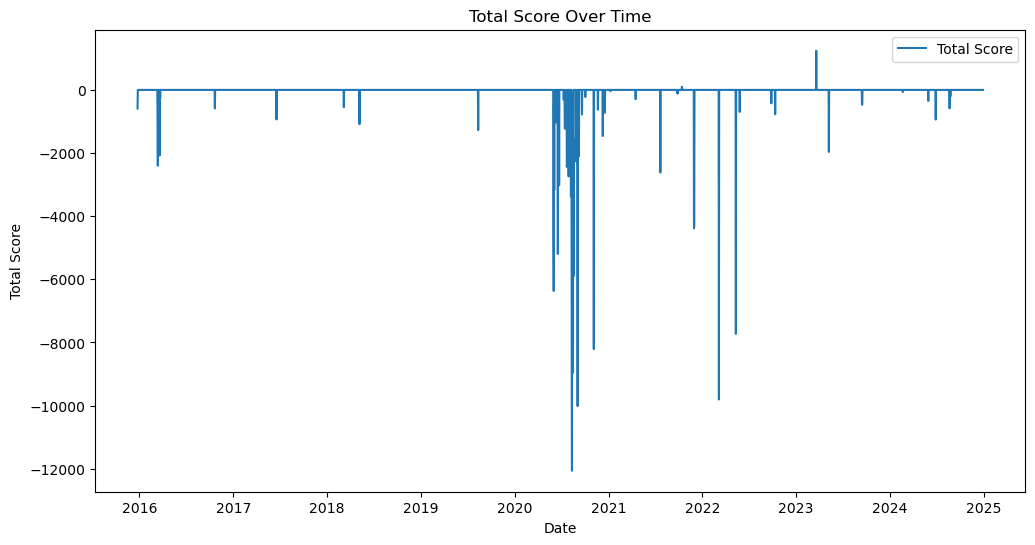

In [164]:
import matplotlib.pyplot as plt

# Plot the data over time
plt.figure(figsize=(12, 6))
plt.plot(Y['Date'], Y['Total Score'], label='Total Score')
plt.xlabel('Date')
plt.ylabel('Total Score')
plt.title('Total Score Over Time')
plt.legend()
plt.show()

---

I'm going to come back to the test / train split later onces I've propperly adjusted normalized the features for the model.

---

---

## Normalize the Features

Normalize the features for better model performance.


---

---

Let's get dates into integers.

---

In [165]:
# Define the starting date
starting_date = target_dates[0]

# Calculate "Days since" for Y
Y['Days_Since'] = (Y['Date'] - starting_date).dt.days

# Update the Date column in Y
Y['Date'] = Y['Days_Since']
Y = Y.drop(columns=['Days_Since'])

# Update the Date and TargetDate columns in each sequence of X
for seq in X:
    seq['Days_Since'] = (seq['Date'] - starting_date).dt.days
    seq['Date'] = seq['Days_Since']
    seq['TargetDays_Since'] = (seq['TargetDate'] - starting_date).dt.days
    seq['TargetDate'] = seq['TargetDays_Since']
    seq.drop(columns=['Days_Since', 'TargetDays_Since'], inplace=True)

# Display the updated dataframes
print("Updated Y:")
display(Y.head())

print("\nUpdated first sequence in X:")
display(X[0].head())

Updated Y:


,Date,Total Score
0,0,-589.428382
1,1,0.000000
2,2,0.000000
3,3,0.000000
4,4,0.000000



Updated first sequence in X:


,Date,ActionGeo_Lat,ActionGeo_Long,AvgTone,TargetDate
3465,-233,0.688684,0.232275,0.282298,0
3466,-237,0.688684,0.232275,0.615931,0
3467,-237,0.688684,0.232275,0.615931,0
3468,-238,0.688684,0.232275,0.711473,0
3469,-238,0.688684,0.232275,0.711473,0


---

Let's norm lat & long

---

In [166]:
from sklearn.preprocessing import MinMaxScaler

sequence=X[0]

# Check the ActionGeo_Lat values
print("ActionGeo_Lat values before scaling:")
print(sequence['ActionGeo_Lat'].describe())  # Summary statistics
print("Unique values:", sequence['ActionGeo_Lat'].unique())

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform latitude and longitude
sequence[['ActionGeo_Lat']] = scaler.fit_transform(sequence[['ActionGeo_Lat']])

print("Normalized sequence:")
display(sequence)

ActionGeo_Lat values before scaling:
count    30.000000
mean      0.688684
std       0.000000
min       0.688684
25%       0.688684
50%       0.688684
75%       0.688684
max       0.688684
Name: ActionGeo_Lat, dtype: float64
Unique values: [0.68868435]
Normalized sequence:


,Date,ActionGeo_Lat,ActionGeo_Long,AvgTone,TargetDate
3465,-233,0.0,0.232275,0.282298,0
3466,-237,0.0,0.232275,0.615931,0
3467,-237,0.0,0.232275,0.615931,0
3468,-238,0.0,0.232275,0.711473,0
3469,-238,0.0,0.232275,0.711473,0
3470,-239,0.0,0.232275,0.438802,0
3471,-239,0.0,0.232275,0.784161,0
3472,-239,0.0,0.232275,0.438802,0
3473,-240,0.0,0.232275,0.573761,0
3474,-240,0.0,0.232275,0.614215,0


In [167]:
X[0]

,Date,ActionGeo_Lat,ActionGeo_Long,AvgTone,TargetDate
3465,-233,0.0,0.232275,0.282298,0
3466,-237,0.0,0.232275,0.615931,0
3467,-237,0.0,0.232275,0.615931,0
3468,-238,0.0,0.232275,0.711473,0
3469,-238,0.0,0.232275,0.711473,0
3470,-239,0.0,0.232275,0.438802,0
3471,-239,0.0,0.232275,0.784161,0
3472,-239,0.0,0.232275,0.438802,0
3473,-240,0.0,0.232275,0.573761,0
3474,-240,0.0,0.232275,0.614215,0


In [168]:
# Split the data into before and after 2021
Y_train = Y[Y['Date'] < '2021-01-01']
Y_test = Y[Y['Date'] >= '2021-01-01']

# Display the resulting dataframes
print("Train Data:")
display(Y_train)
print("\nTest Data:")
display(Y_test)

# Add sequences from X to the split data
X_train = [seq for seq, date in zip(X, target_dates) if date < pd.Timestamp('2021-01-01')]
X_test = [seq for seq, date in zip(X, target_dates) if date >= pd.Timestamp('2021-01-01')]

# Display the number of sequences in each split
print(f"Number of sequences in X_train: {len(X_train)}")
print(f"Number of sequences in X_test: {len(X_test)}")

TypeError: Invalid comparison between dtype=int64 and str

---

# LSTM Model

### **Building the LSTM Model**

We’ll now construct an LSTM-based neural network to process the input tensor \( \mathbf{X} \in \mathbb{R}^{B \times T \times F} \) and predict the target score \( \mathbf{y} \in \mathbb{R}^B \). The goal is to use the sequences from \( X \) and the labels from \( Y \) to train a regression model.


---

---

### **Step 1: Convert Data to Numpy Arrays**

Ensure the data is in the proper format for TensorFlow/Keras.

---

In [73]:
import numpy as np

# Convert X_train and X_test into 3D numpy arrays
X_train = np.array([seq.values for seq in X_train])  # Each sequence is converted to a 2D array
X_test = np.array([seq.values for seq in X_test])

# Convert Y_train and Y_test into 1D numpy arrays
y_train = np.array(Y_train['Total Score'].values)
y_test = np.array(Y_test['Total Score'].values)

# Verify the shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (1834, 30, 5), y_train shape: (1834,)
X_test shape: (1458, 30, 5), y_test shape: (1458,)


---

### **Step 3: Build the LSTM Model**

Define an LSTM-based architecture with Keras.


---

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define the model
model = Sequential([
    LSTM(64, input_shape=(30, 6), return_sequences=False),  # 30 time steps, 6 features
    Dropout(0.2),  # Regularization
    Dense(32, activation='relu'),
    Dropout(0.2),  # Regularization
    Dense(1, activation='linear')  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the model summary
model.summary()

/opt/anaconda3/envs/civil_unrest/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

---

### **Step 4: Train the Model**

Fit the model on the training data and validate on the test data.

---

In [ ]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 5 and 6 for '{{node sequential_3_1/lstm_5_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_3_1/lstm_5_1/strided_slice_2, sequential_3_1/lstm_5_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,5], [6,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 5), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=True

---

### **Step 5: Evaluate the Model**

Assess the model's performance on the test set.

---

In [28]:
# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

ValueError: Invalid dtype: object

---

### **Step 6: Visualize Training Progress**

Plot the training and validation loss over epochs.

---

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

---

### **Step 7: Make Predictions**

Make predictions for specific sequences.


---

In [ ]:
# Select a sequence from the test set
sample_sequence = X_test[0].reshape(1, 30, 6)  # Reshape for single prediction

# Predict the score
predicted_score = model.predict(sample_sequence)
print(f"Predicted Score: {predicted_score[0][0]}")